In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Any

from new_data_loader import DataLoader
from new_backtester import SimpleBacktester, BacktestConfig
from new_features_numba import rolling_z_numba

In [2]:
def compute_imbalance(bid_qty: np.ndarray, ask_qty: np.ndarray) -> np.ndarray:
    denom = bid_qty + ask_qty
    out = np.full_like(denom, np.nan, dtype=np.float64)
    mask = denom > 0
    out[mask] = (bid_qty[mask] - ask_qty[mask]) / denom[mask]
    return out


In [3]:
def infer_median_ns(ts: pd.Series) -> int:
    ts_ns = ts.to_numpy(dtype="datetime64[ns]").astype("int64")
    if len(ts_ns) < 2:
        return 10_000_000  # fallback 10ms
    diffs = np.diff(ts_ns)
    diffs = diffs[diffs > 0]
    if len(diffs) == 0:
        return 10_000_000
    return int(np.median(diffs))


def compute_zscore_from_ts(
    imbalance: np.ndarray,
    ts: pd.Series,
    z_window_minutes: float,
):
    window_ns = int(z_window_minutes * 60 * 1_000_000_000)
    median_ns = infer_median_ns(ts)

    z_window = max(20, window_ns // median_ns)

    z = rolling_z_numba(
        imbalance.astype(np.float64),
        z_window
    )

    print(
        f"[INFO] median_dt ≈ {median_ns/1e6:.3f} ms | "
        f"Z-window = {z_window} ticks"
    )

    return z, z_window


In [4]:
def make_signal(z: np.ndarray, z_th: float):
    def signal(info: Dict[str, Any], state: Dict[str, Any]):
        i = info["i"]
        zi = z[i]

        if np.isnan(zi):
            return None
        if zi >= z_th:
            return "LONG"
        if zi <= -z_th:
            return "SHORT"
        return None

    return signal


In [5]:
def run_daily_imbalance_strategy(
    *,
    root: str | Path,
    symbol: str,
    ymd: str,
    config: BacktestConfig,
    freq: str = "10ms",
    z_window_minutes: float = 30.0,
    z_th: float = 2.0,
):
    loader = DataLoader(root, tz="UTC")

    quotes = loader.load_bookticker_one_day(symbol, ymd, freq=freq)
    if quotes is None or quotes.empty:
        print(f"[WARN] no data for {ymd}")
        return pd.DataFrame(), config.initial_capital, 0.0, None, None

    print(f"[INFO] quotes rows = {len(quotes):,}")

    bid_qty = quotes["best_bid_qty"].to_numpy(dtype=np.float64)
    ask_qty = quotes["best_ask_qty"].to_numpy(dtype=np.float64)

    imbalance = compute_imbalance(bid_qty, ask_qty)

    z, z_window = compute_zscore_from_ts(
        imbalance=imbalance,
        ts=quotes["ts"],
        z_window_minutes=z_window_minutes,
    )

    # ===== 디버깅 핵심 로그 =====
    print(
        "[DEBUG] z stats:",
        "non-nan =", np.sum(~np.isnan(z)),
        "min =", np.nanmin(z),
        "max =", np.nanmax(z),
        "std =", np.nanstd(z),
    )
    print(
        "[DEBUG] signal count:",
        "LONG =", np.sum(z >= z_th),
        "SHORT =", np.sum(z <= -z_th),
    )

    signal = make_signal(z, z_th)

    # ⭐ execution은 반드시 quotes 전체를 넘긴다
    bt = SimpleBacktester(quotes, config=config)

    trades, final_capital, turnover = bt.run(signal)

    print(
        f"[RESULT] trades={len(trades)} | "
        f"turnover={turnover:.2f} | "
        f"final_capital={final_capital:.2f}"
    )

    return trades, final_capital, turnover, z, imbalance


In [6]:
config = BacktestConfig(
    initial_capital=100.0,
    maker_fee_bp=5.0,
    taker_fee_bp=2.0,
    latency_ms=0,
    decision_ms=0,
    max_holding_seconds=300,
    limit_ratio=0.7,
    target_bp=17.0,
    partial_bp=13.0,
    stop_bp=10.0,
    partial_as_limit=True,
)

trades, capital, turnover, z, imbalance = run_daily_imbalance_strategy(
    root="D:/fpa_data",
    symbol="DOGEUSDT",
    ymd="2024-03-02",
    config=config,
    freq="10ms",
    z_window_minutes=30,
    z_th=1.7,
)

display(trades.tail())

[INFO] quotes rows = 2,587,094
[INFO] median_dt ≈ 20.000 ms | Z-window = 90000 ticks
[DEBUG] z stats: non-nan = 2497095 min = -1.820708475098345 max = 1.8269220778989659 std = 1.0013665342413278
[DEBUG] signal count: LONG = 26500 SHORT = 13419
[RESULT] trades=611 | turnover=63627.74 | final_capital=103.59


,ts,type,side,capital_before,capital_after
606,2024-03-02 23:55:02.640,ENTER,LONG,104.035194,103.983176
607,2024-03-02 23:56:14.950,EXIT,NaN,103.983176,103.855647
608,2024-03-02 23:56:16.980,ENTER,LONG,103.855647,103.803719
609,2024-03-02 23:57:09.570,EXIT,NaN,103.803719,103.643239
610,2024-03-02 23:57:09.630,ENTER,LONG,103.643239,103.591417


In [7]:
from new_performance import build_equity_full, performance_metrics
# quotes는 하루 runner 안에서 썼던 것과 동일해야 함
loader = DataLoader("D:/fpa_data", tz="UTC")
quotes = loader.load_bookticker_one_day(
    symbol="DOGEUSDT",
    ymd="2024-03-02",
    freq="10ms",
)

equity_full = build_equity_full(
    trades_df=trades,
    quote_ts=quotes["ts"],
    initial_capital=config.initial_capital,
)

metrics = performance_metrics(
    equity_full=equity_full,
    turnover=turnover,
    initial_capital=config.initial_capital,
)

metrics

{'cum_pnl': 3.591417217189303,
 'cum_return_simple': 0.03591417217189303,
 'sharpe_daily': 0.00033598004461354424,
 'sharpe_annualized': 13.345979982993299,
 'max_drawdown': -7.900880966438152,
 'turnover_ratio': 636.2773644101914}

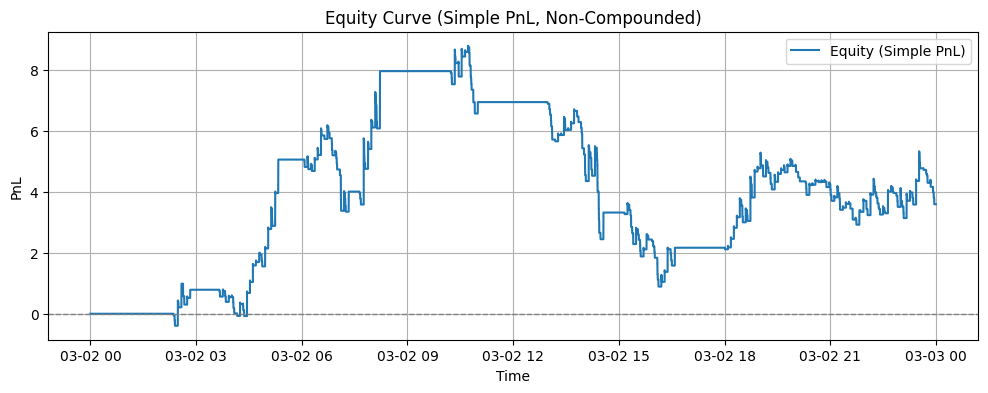

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(equity_full.index, equity_full.values, label="Equity (Simple PnL)")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)

plt.title("Equity Curve (Simple PnL, Non-Compounded)")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
bps = metrics["cum_pnl"] / turnover * 1e4
bps

0.5644420842345116

위에는 하루단위
아래는 긴 기간단위. sharpe 연율화 믿어봄직 함.


=== 2024-01-01 | start_capital=100.00 ===
[INFO] quotes rows = 2,373,123
[INFO] median_dt ≈ 20.000 ms | Z-window = 90000 ticks
[DEBUG] z stats: non-nan = 2283124 min = -1.7982119173564188 max = 1.8480623245224603 std = 1.0011288101115083
[DEBUG] signal count: LONG = 45929 SHORT = 68200
[RESULT] trades=401 | turnover=40393.41 | final_capital=102.76

=== 2024-01-02 | start_capital=102.76 ===
[INFO] quotes rows = 3,263,426
[INFO] median_dt ≈ 10.000 ms | Z-window = 180000 ticks
[DEBUG] z stats: non-nan = 3083427 min = -1.599047946537361 max = 1.5888657336692726 std = 1.0012245084059552
[DEBUG] signal count: LONG = 19163 SHORT = 61517
[RESULT] trades=358 | turnover=36615.16 | final_capital=104.58

=== 2024-01-03 | start_capital=104.58 ===
[INFO] quotes rows = 3,049,387
[INFO] median_dt ≈ 10.000 ms | Z-window = 180000 ticks
[DEBUG] z stats: non-nan = 2869388 min = -1.570654962201483 max = 1.6095949216851568 std = 1.000305348609629
[DEBUG] signal count: LONG = 23649 SHORT = 9429
[RESULT] tra

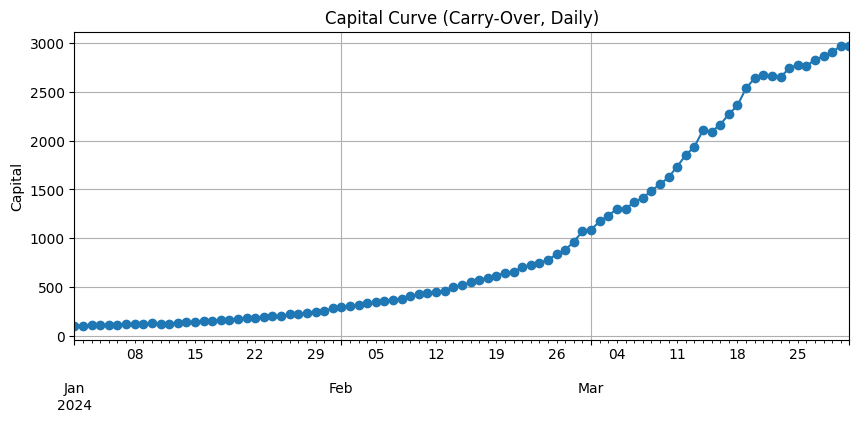

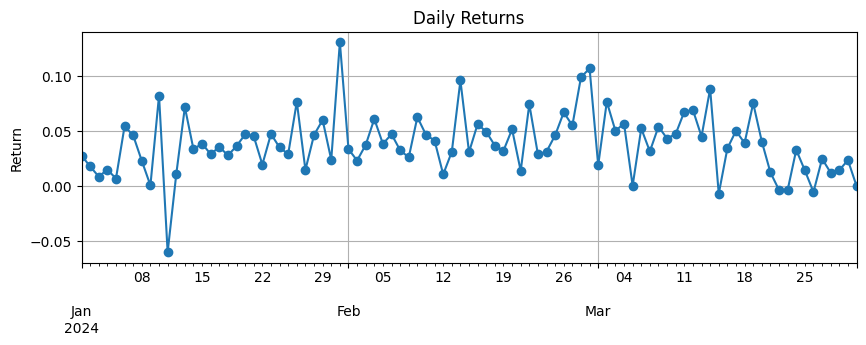


===== SUMMARY =====
Start capital : 100.0
End capital   : 2974.167049381933
Total return  : 28.741670493819328
Daily Sharpe  : 1.3734805224633424


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from new_data_loader import DataLoader
from new_backtester import BacktestConfig

# =========================
# 설정
# =========================
ROOT = "D:/fpa_data"
SYMBOL = "BTCUSDT"

START_DATE = "2024-01-01"
END_DATE   = "2024-03-31"

FREQ = "10ms"
Z_WINDOW_MINUTES = 30.0
Z_TH = 1.5

config = BacktestConfig(
    initial_capital=100.0,
    maker_fee_bp=5.0,
    taker_fee_bp=2.0,
    latency_ms=0,
    decision_ms=0,
    max_holding_seconds=300,
    limit_ratio=0.7,
    target_bp=17.0,
    partial_bp=13.0,
    stop_bp=10.0,
    partial_as_limit=True,
)

# =========================
# 날짜 리스트
# =========================
loader = DataLoader(ROOT, tz="UTC")
dates = loader._date_range(START_DATE, END_DATE)

# =========================
# 백테스트 루프
# =========================
all_trades = []
daily_returns = []
daily_capitals = []

capital = config.initial_capital

for ymd in dates:
    print(f"\n=== {ymd} | start_capital={capital:.2f} ===")

    day_config = BacktestConfig(
        **{**config.__dict__, "initial_capital": capital}
    )

    trades, capital_end, turnover, z, imbalance = run_daily_imbalance_strategy(
        root=ROOT,
        symbol=SYMBOL,
        ymd=ymd,
        config=day_config,
        freq=FREQ,
        z_window_minutes=Z_WINDOW_MINUTES,
        z_th=Z_TH,
    )

    # 하루 수익률 (carry 기준)
    daily_ret = capital_end / capital - 1.0

    daily_returns.append(daily_ret)
    daily_capitals.append(capital_end)

    if trades is not None and not trades.empty:
        trades["ymd"] = ymd   # 날짜 태깅 (중요)
        all_trades.append(trades)

    capital = capital_end  # 다음 날로 carry

# =========================
# Daily series
# =========================
daily_ret_series = pd.Series(
    daily_returns,
    index=pd.to_datetime(dates),
    name="daily_return"
)

capital_series = pd.Series(
    daily_capitals,
    index=pd.to_datetime(dates),
    name="capital"
)

# =========================
# ✅ 네가 말한 "일반적인 Sharpe"
# =========================
mean_daily = daily_ret_series.mean()
std_daily  = daily_ret_series.std(ddof=0)

daily_sharpe_standard = (
    mean_daily / std_daily if std_daily > 0 else np.nan
)

print("\n===== DAILY SHARPE (STANDARD DEFINITION) =====")
print("Mean daily return :", mean_daily)
print("Std  daily return :", std_daily)
print("Daily Sharpe      :", daily_sharpe_standard)

# =========================
# Capital Curve (이게 핵심)
# =========================
plt.figure(figsize=(10, 4))
capital_series.plot(marker="o")
plt.title("Capital Curve (Carry-Over, Daily)")
plt.ylabel("Capital")
plt.grid(True)
plt.show()

# =========================
# Daily Return Plot
# =========================
plt.figure(figsize=(10, 3))
daily_ret_series.plot(marker="o")
plt.title("Daily Returns")
plt.ylabel("Return")
plt.grid(True)
plt.show()

# =========================
# 간단 요약
# =========================
print("\n===== SUMMARY =====")
print("Start capital :", config.initial_capital)
print("End capital   :", capital_series.iloc[-1])
print("Total return  :", capital_series.iloc[-1] / config.initial_capital - 1)
print("Daily Sharpe  :", daily_sharpe_standard)

In [11]:
win_rate_daily = (daily_ret_series > 0).mean()
print("Daily Win Rate:", win_rate_daily)

Daily Win Rate: 0.9340659340659341
